# Heart Attack Prediction Model


## Dataset preparation and summary

### Dataset information

-  Age : Age of the patient
-  Sex : Sex of the patient
-  exng: exercise induced angina (1 = yes; 0 = no)
-  caa: number of major vessels (0-3)
-  cp : Chest Pain type chest pain type
    -  Value 1: typical angina
    -  Value 2: atypical angina
    -  Value 3: non-anginal pain
    -  Value 0: asymptomatic
-  trtbps : resting blood pressure (in mm Hg)
-  chol : cholestoral in mg/dl fetched via BMI sensor
-  fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
-  restecg : resting electrocardiographic results
    -  Value 0: normal
    -  Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    -  Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
-  thalachh : maximum heart rate achieved
-  oldpeak : ST depression induced by exercise relative to rest
-  slp  : the slope of the peak exercise ST segment 
    -  Value 0: downsloping
    -  Value 1: flat
    -  Value 2: downsloping
-  thall : 
    -  Value 1: fixed defect 
    -  Value 2: normal
    -  Value 3: reversible defect
-  output : 0= less chance of heart attack 1= more chance of heart attack

### Packages

In [1]:
import pandas as pd 
import os 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
#from plotnine import *
from sklearn.neighbors import KNeighborsClassifier

### Dataset exploration

In [2]:
#heart_df = pd.read_csv(os.path.join(os.getcwd(), "data", "heart.csv"))
heart_df = pd.read_csv(".\data\heart.csv")
heart_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


This dataset has {{heart_df.shape[0]}} observations and {{heart_df.shape[1]}} variables.

In [3]:
# Checking for any rows with NA values
heart_df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [4]:
# Viewing the dataset size for different categories
# Grouping by age and sex to see the data is distributed 

heart_df.groupby(['sex', 'age']).size().sort_values(ascending=False)

sex  age
1    58     13
     57     13
     59     13
     52     12
     54     11
            ..
0    59      1
     52      1
     48      1
     37      1
1    77      1
Length: 73, dtype: int64

In [5]:
# Summary statistics on the whole dataset to get a quick overview of the data. 
heart_df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Initially while looking at the data at a very high level we can draw some very simple conclusions. 
It appears from this set of data the average male aged around 55 seem to experience a higher chance of suffering from a heart attack. Whilst this is a very simplistic view of the dataset I will be exploring this further with the use of some classifier models to predict whether a patient will have a higher chance of having a heart attack.

There are a wide variety of feature variables in the data which will be used to predict the outcome or the target variable. 
Whilst there are a number of major factors contributing to a heart attack my initial assumptions are that the main feature variables that will be heavily reliant on predicting the outcome will be the following (in no particular order of importance):  
-  chol
-  trtbps
-  oldpeak 

chol represents the cholesteral level in the patient. 

> When you have too much “bad” cholesterol in your body, it can start to pose a problem. It contributes to fatty deposits in the arteries called plaque, which can cause heart disease. 
When that plaque builds up, it makes it harder for blood to flow, and these deposits can eventually break and form a clot that leads to a heart attack.[<sup>1</sup>](#fn1)

However there are some alternative sources which contradict a common understanding that cholesterol leads to heart attacks, this article suggests that in a peer reviewed journal written in 2013 that looking at just cholesterol is not enough to determine a heart attack eventhood.[<sup>2</sup>](#fn2)

As I suggested previously there are a number of variables that combine and contribute to a likelyhood of a heart attack happening which brings me onto the next variable I predict will also be an important variable in the model. 

trtbps is the resting blood pressure in the patient. 

>In most cases, damage done from high blood pressure (HBP or hypertension) occurs over time. Left undetected or uncontrolled, high blood pressure can lead to:  
>Heart attack — High blood pressure damages arteries that can become blocked and prevent blood flow to the heart muscle.[<sup>3</sup>](#fn3)


The important thing to note here is that widely known and described in the article - high blood pressure can contribute to heart attacks but usually over a period of time rather than a sudden change in blood pressure.  


The next variable I think will be one main determining factor is caa which represents the number of the major vessels that are blocked by atherosclerosis. 

>Coronary heart disease (CHD) is the leading cause of heart attacks. CHD is a condition in which the coronary arteries (the major blood vessels that supply the heart with blood) become clogged with deposits of cholesterol. These deposits are called plaques.
>Before a heart attack, one of the plaques ruptures (bursts), causing a blood clot to form at the site of the rupture. The clot may block the supply of blood to the heart, triggering a heart attack.[<sup>4</sup>](#fn4)


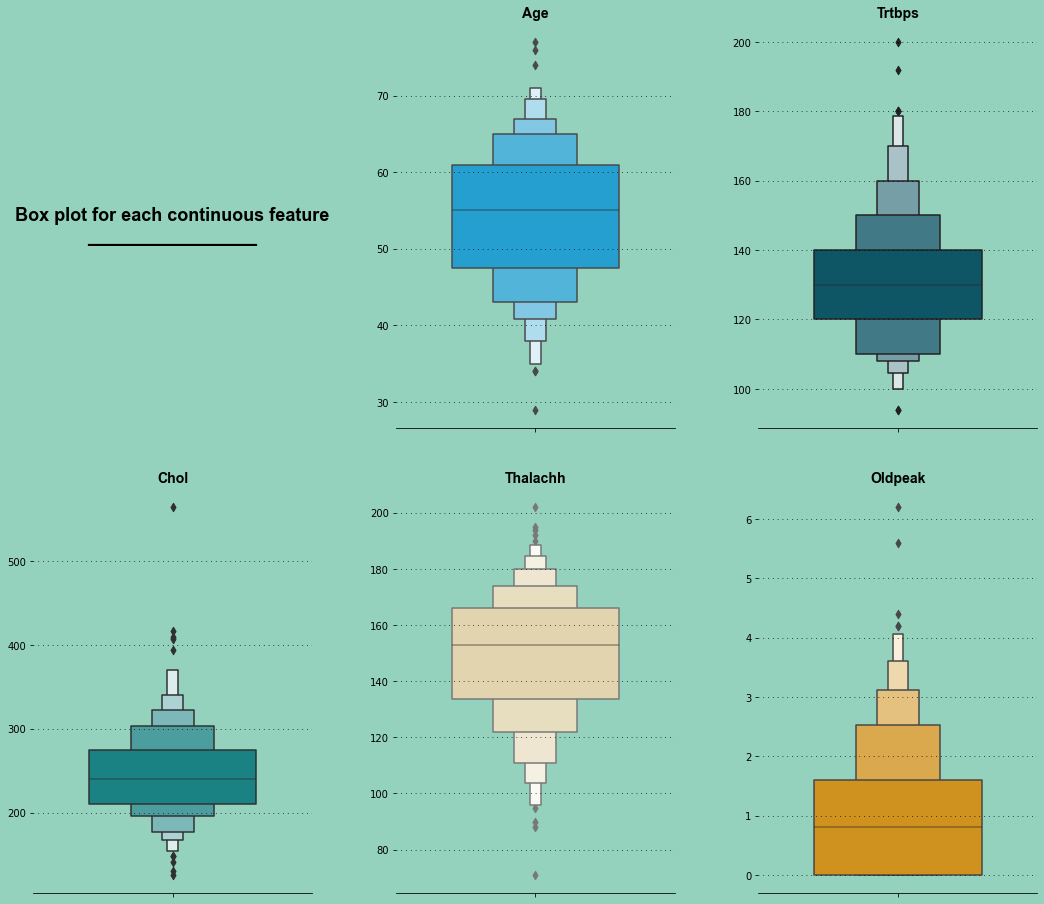

In [4]:
### Some exploratory visualisations

### Box plot of continuous variables 

fig = plt.figure(figsize=(18,16))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])

background_colour = "#94D2BD"
font = 'arial'
font_weight = 'bold'
ax_fontsize = '14'
colour_palette = ["#08acec","#005F73","#0A9396","#E9D8A6","#EE9B00"]
fig.patch.set_facecolor(background_colour) 
ax0.set_facecolor(background_colour) 
ax1.set_facecolor(background_colour) 
ax2.set_facecolor(background_colour) 
ax3.set_facecolor(background_colour) 
ax4.set_facecolor(background_colour) 
ax5.set_facecolor(background_colour) 

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Box plot for each continuous feature\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight = font_weight,
         fontfamily = font,
         color="#000000")

# Age 
ax1.set_title('Age', fontsize = ax_fontsize, fontweight = font_weight, fontfamily = font)
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax1,y=heart_df['age'],palette=[colour_palette[0]],width=0.6)
ax1.set_xlabel("")
ax1.set_ylabel("")


# Trtbps 
ax2.set_title('Trtbps', fontsize = ax_fontsize, fontweight = font_weight, fontfamily = font)
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax2,y=heart_df['trtbps'],palette=[colour_palette[1]],width=0.6)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Chol 
ax3.set_title('Chol', fontsize = ax_fontsize, fontweight = font_weight, fontfamily = font)
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax3,y=heart_df['chol'],palette=[colour_palette[2]],width=0.6)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Thalachh 
ax4.set_title('Thalachh', fontsize = ax_fontsize, fontweight = font_weight, fontfamily = font)
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax4,y=heart_df['thalachh'],palette=[colour_palette[3]],width=0.6)
ax4.set_xlabel("")
ax4.set_ylabel("")

# oldpeak 
ax5.set_title('Oldpeak', fontsize = ax_fontsize, fontweight = font_weight, fontfamily = font)
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax5,y=heart_df['oldpeak'],palette=[colour_palette[4]],width=0.6)
ax5.set_xlabel("")
ax5.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False);

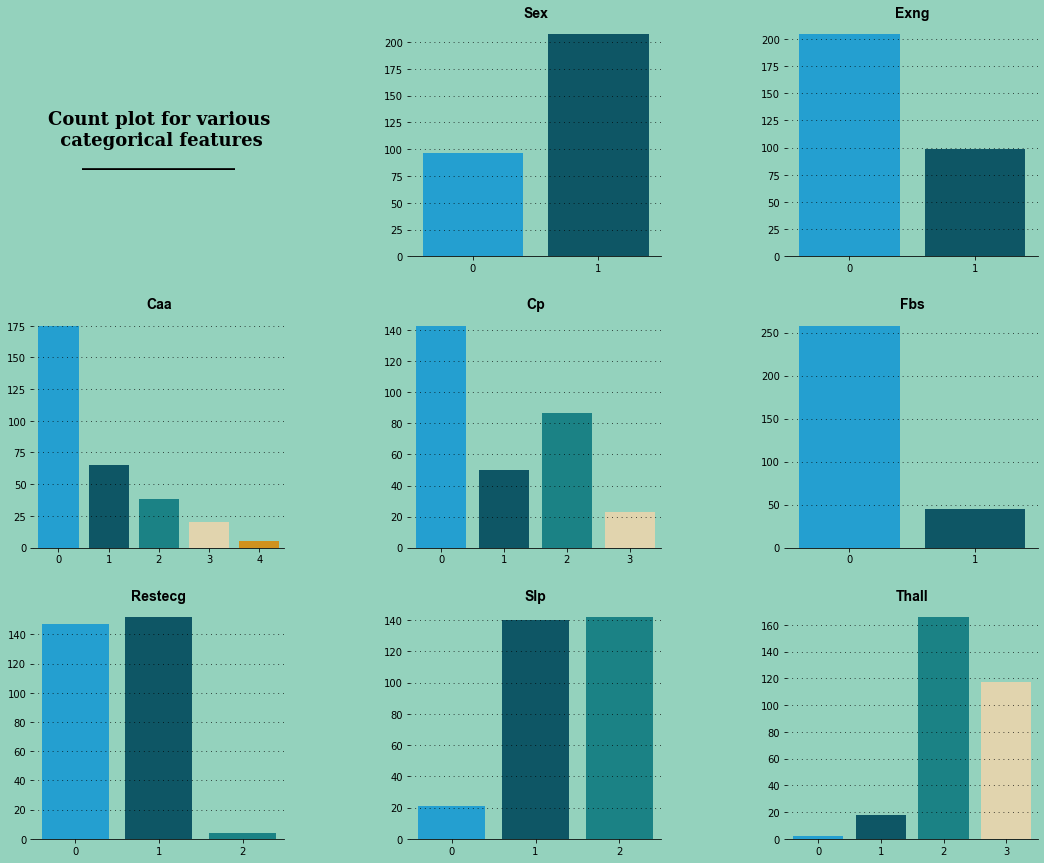

In [16]:
## Count plot for categorical variables 

fig  =  plt.figure(figsize = (18,15))
gs  =  fig.add_gridspec(3,3)
gs.update(wspace = 0.5, hspace = 0.25)
ax0  =  fig.add_subplot(gs[0,0])
ax1  =  fig.add_subplot(gs[0,1])
ax2  =  fig.add_subplot(gs[0,2])
ax3  =  fig.add_subplot(gs[1,0])
ax4  =  fig.add_subplot(gs[1,1])
ax5  =  fig.add_subplot(gs[1,2])
ax6  =  fig.add_subplot(gs[2,0])
ax7  =  fig.add_subplot(gs[2,1])
ax8  =  fig.add_subplot(gs[2,2])


fig.patch.set_facecolor(background_colour) 
ax0.set_facecolor(background_colour) 
ax1.set_facecolor(background_colour) 
ax2.set_facecolor(background_colour) 
ax3.set_facecolor(background_colour) 
ax4.set_facecolor(background_colour) 
ax5.set_facecolor(background_colour) 
ax6.set_facecolor(background_colour) 
ax7.set_facecolor(background_colour) 
ax8.set_facecolor(background_colour) 

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left = False, bottom = False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Count plot for various\n categorical features\n_________________',
         horizontalalignment = 'center',
         verticalalignment = 'center',
         fontsize = 18, fontweight = 'bold',
         fontfamily = 'serif',
         color = "#000000")

# Sex count
ax1.set_title('Sex', fontsize  =  ax_fontsize, fontweight  =  font_weight, fontfamily  =  font)
ax1.grid(color = '#000000', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,5))
sns.countplot(ax = ax1,data = heart_df,x = 'sex',palette = colour_palette)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Exng count
ax2.set_title('Exng', fontsize  =  ax_fontsize, fontweight  =  font_weight, fontfamily  =  font)
ax2.grid(color = '#000000', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,5))
sns.countplot(ax = ax2,data = heart_df,x = 'exng',palette = colour_palette)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Caa count
ax3.set_title('Caa', fontsize  =  ax_fontsize, fontweight  =  font_weight, fontfamily  =  font)
ax3.grid(color = '#000000', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,5))
sns.countplot(ax = ax3,data = heart_df,x = 'caa',palette = colour_palette)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Cp count
ax4.set_title('Cp', fontsize  =  ax_fontsize, fontweight  =  font_weight, fontfamily  =  font)
ax4.grid(color  =  '#000000', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,5))
sns.countplot(ax = ax4,data = heart_df,x = 'cp',palette = colour_palette)
ax4.set_xlabel("")
ax4.set_ylabel("")

# Fbs count
ax5.set_title('Fbs', fontsize = ax_fontsize, fontweight = font_weight, fontfamily = font)
ax5.grid(color = '#000000', linestyle = ':', axis = 'y', zorder = 0, dashes = (1,5))
sns.countplot(ax = ax5,data = heart_df,x = 'fbs',palette = colour_palette)
ax5.set_xlabel("")
ax5.set_ylabel("")

# Restecg count
ax6.set_title('Restecg', fontsize = ax_fontsize, fontweight = font_weight, fontfamily = font)
ax6.grid(color = '#000000', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,5))
sns.countplot(ax = ax6,data = heart_df,x = 'restecg',palette = colour_palette)
ax6.set_xlabel("")
ax6.set_ylabel("")

# Slp count
ax7.set_title('Slp', fontsize  =  ax_fontsize, fontweight  =  font_weight, fontfamily  =  font)
ax7.grid(color = '#000000', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,5))
sns.countplot(ax = ax7,data = heart_df,x = 'slp',palette = colour_palette)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Thall count
ax8.set_title('Thall', fontsize  =  ax_fontsize, fontweight  =  font_weight, fontfamily  =  font)
ax8.grid(color = '#000000', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,5))
sns.countplot(ax = ax8,data = heart_df,x = 'thall',palette = colour_palette)
ax8.set_xlabel("")
ax8.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)

### Choosing feature variables

In [6]:
#Splitting our dataset into feature data (X) and target data (y). 

X = heart_df.drop('output', 1)
y = heart_df[['output']]

C:\Users\dylan\AppData\Local\Temp\ipykernel_7048\2203312329.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = heart_df.drop('output', 1)


In [ ]:
# Creating the KNN model to use with n equal to 4 (chosen at random by default)
knn = KNeighborsClassifier(n_neighbors=4)

# Fitting the knn model with the feature and target data created previously
knn.fit(X.values, np.ravel(y))

In [ ]:
# Viewing the first row of the original dataframe for input into the model. 

print(heart_df.iloc[1,:])
print(heart_df.iloc[302,:])

In [ ]:
# testing out prediction using a random existing record from the dataset. 
# Using the first row in our dataset in the knn model it was able to predict the same outcome as in the original dataset. 


## Using the last row of the dataframe the model did not predict correctly. 
knn.predict([[57, 0, 1, 130, 236, 0, 0, 174, 0, 0, 1, 1, 2]])

## References

<span id="fn1">[1: https://www.everydayhealth.com/heart-health/cholesterol-and-heart-attack-risk/](https://www.everydayhealth.com/heart-health/cholesterol-and-heart-attack-risk/) </span>  
<span id="fn2">[2: https://www.healthline.com/health-news/cholesterol-and-heart-attacks](https://www.healthline.com/health-news/cholesterol-and-heart-attacks) </span>  
<span id="fn3">[3: https://www.heart.org/en/health-topics/high-blood-pressure/health-threats-from-high-blood-pressure](https://www.heart.org/en/health-topics/high-blood-pressure/health-threats-from-high-blood-pressure)  
<span id="fn4">[4: https://www.nhs.uk/conditions/heart-attack/causes/](https://www.nhs.uk/conditions/heart-attack/causes/)